#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

/home/franko/anaconda3/envs/critical/bin/python


# Install dependencies:

In [2]:
install_packages = False
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

# Imports

In [3]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [4]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

In [5]:
# Set pandas print options
#This will improve readability of printed pandas dataframe.


In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [7]:
output_path = "./data/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [8]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [9]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [10]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.45941934
n_clusters: 102 silhouette_avg: 0.3221799
n_clusters: 202 silhouette_avg: 0.3026804
n_clusters: 302 silhouette_avg: 0.29364547
n_clusters: 402 silhouette_avg: 0.28284365
n_clusters: 502 silhouette_avg: 0.29546988
n_clusters: 602 silhouette_avg: 0.2910272
n_clusters: 702 silhouette_avg: 0.2885458
n_clusters: 802 silhouette_avg: 0.2780615
n_clusters: 902 silhouette_avg: 0.27708298


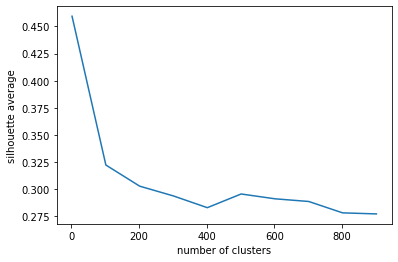

In [11]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=1000 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [12]:
number_of_clusters =  200
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 179      3
182      5
190      6
151      6
26       7
68       7
133      8
72       8
175      9
167      9
90       9
94       9
58       9
171      9
102     10
35      10
59      11
162     11
80      11
106     11
89      12
2       12
180     12
111     13
81      13
104     13
124     14
101     14
197     14
76      14
145     15
125     15
147     15
107     15
154     16
119     16
146     17
121     17
156     17
128     18
99      18
155     18
46      18
148     19
88      20
36      20
187     20
184     21
45      21
25      22
110     23
24      23
112     23
193     23
86      23
97      25
34      25
164     25
47      25
189     25
136     25
139     26
165     27
0       27
195     27
95      28
127     28
54      28
130     29
4       29
191     29
169     29
188     30
108     30
105     30
64      30
77      31
41      32
17      33
37      34
71      34
172     34
126     35
163     35
92      35
123     35
91      36
144     36
174     36
116  

In [13]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [14]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

/home/franko/anaconda3/envs/critical/lib/python3.6/site-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

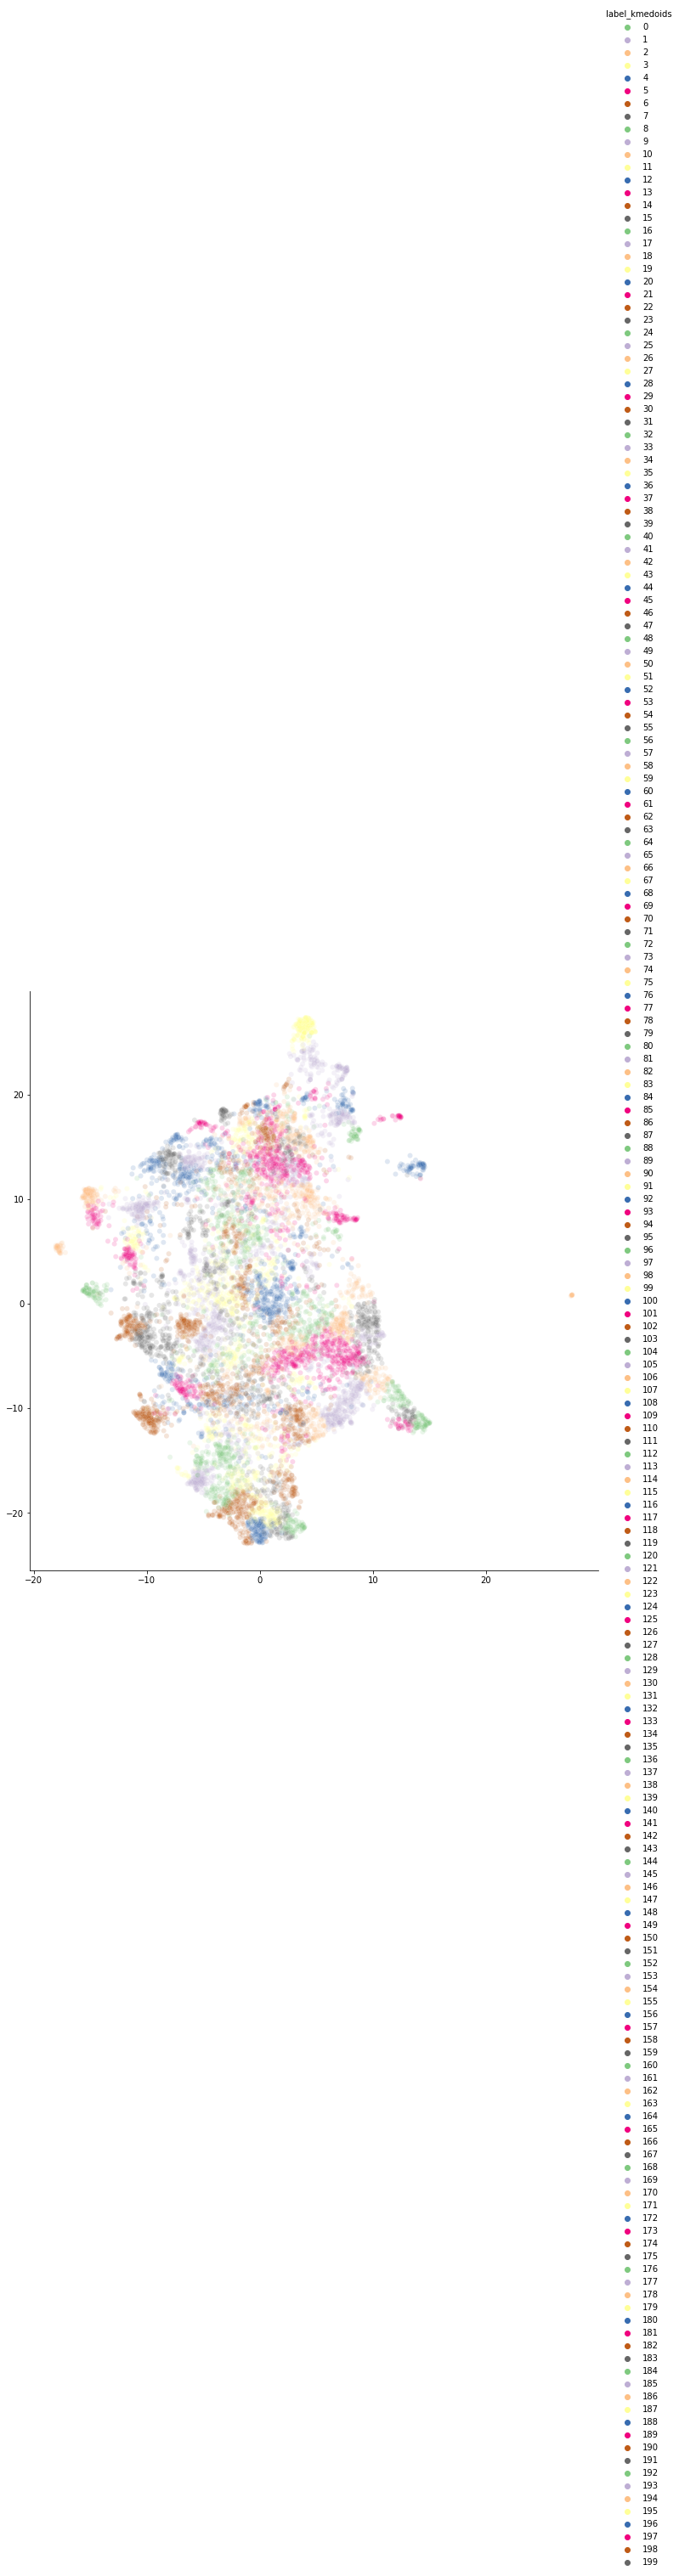

In [15]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

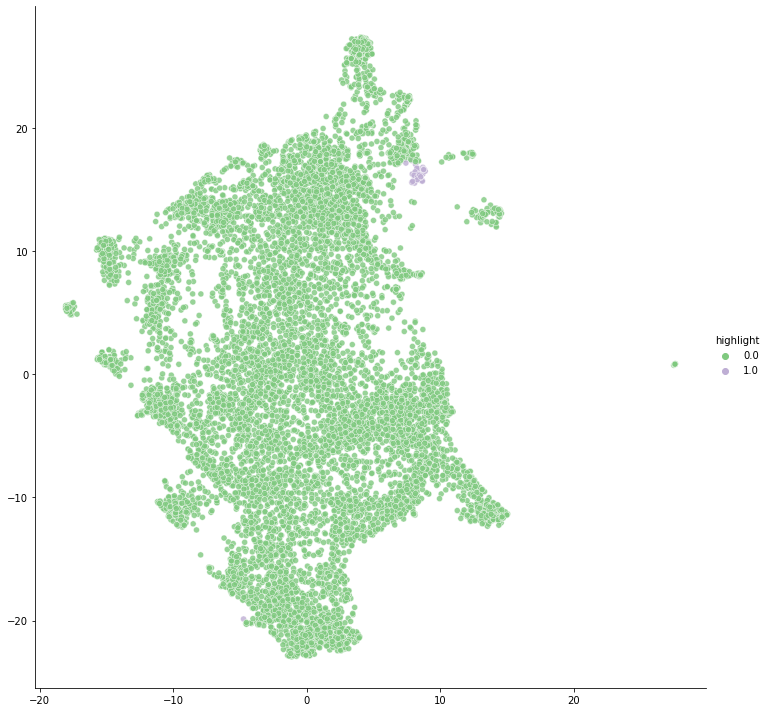

In [23]:
## Choose a cluster to higlight:
cluster_num = 8

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [24]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
9653,2020-10-01 02:05:24,Jotaro Kujo,"@Joshua Kenny no, companies only exist because they're so big we have no choice but to buy from them indirectly",1,"@ no, companies only exist because they're so big we have no\nchoice but to buy from them indirectly\n\n",-1,0,5.960464e-08,0.0
9526,2020-09-30 15:03:08,TR GOLD,Привет ...,0,Привет ...\n\n,-1,1,0.000000e+00,0.0
4363,2020-10-05 13:52:44,Rick TD,"@Ryan M. Do you know what any of these acronyms mean pertaining to climate science... UHI, UAH, TSI, RSS and GCR ?",1,"@ Do you know what any of these acronyms mean pertaining to climate\nscience... UHI, UAH, TSI, RSS and GCR ?\n\n",-1,2,0.000000e+00,0.0
339,2020-09-29 14:42:59,Rafael Losada,"I WANT IT, I NEED IT.",1,"I WANT IT, I NEED IT.\n\n",-1,3,0.000000e+00,0.0
4124,2020-10-03 18:24:52,Ivan Miller,I would like to learn about fungi biology. :),0,I would like to learn about fungi biology. :)\n\n,-1,4,0.000000e+00,0.0
5778,2020-10-03 19:34:43,Wrod of Dog,"That's not maximum. That's actually pretty mild. Deadly heat days are thing, too. They're a big part of the coming problems",1,"That's not maximum. That's actually pretty mild. heat days are thing,\ntoo. They're a big part of the coming problems\n\n",-1,5,0.000000e+00,0.0
8524,2020-10-01 10:46:34,Mohammed Najl,"Michael it’s not renewable, but it’s about as close as we can get. It lasts for several million years, and the only byproduct is steam.",1,"it’s not renewable, but it’s about as close as we can get. It lasts\nfor several million years, and the only byproduct is steam.\n\n",-1,6,0.000000e+00,0.0
6934,2020-10-02 11:59:26,Anagnorisis- for the love of learning,Literally every person: IT IS YOUR HECKIN PROBLEM DO SOMETHING OHMYGAHD,1,Literally every : IT IS YOUR HECKIN PROBLEM DO SOMETHING OHMYGAHD\n\n,-1,7,1.192093e-07,0.0
4995,2020-10-02 14:17:25,Trugillo John Balian,ThE Birds ArE BacK<br />:),0,ThE Birds ArE BacK \n:)\n\n,-1,8,0.000000e+00,1.0
5264,2020-10-02 07:14:23,Colin Prower,First off Co2 is good for the planet co1 is the real reason why everything is changing,0,First off Co2 is good for the planet co1 is the real reason why everything is\nchanging\n\n,-1,9,0.000000e+00,0.0


In [25]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  27 mean distance from center:  0.0013007058441871777 Proportion of replies: 62.96296296296296
1 number of samples:  78 mean distance from center:  0.0012490993867686484 Proportion of replies: 50.0
2 number of samples:  12 mean distance from center:  9.934107758624577e-07 Proportion of replies: 100.0
3 number of samples:  50 mean distance from center:  0.001312017411692068 Proportion of replies: 78.0
4 number of samples:  29 mean distance from center:  0.0011460534551588353 Proportion of replies: 37.93103448275862
5 number of samples:  152 mean distance from center:  0.0010584138181002345 Proportion of replies: 64.47368421052632
6 number of samples:  161 mean distance from center:  0.0012180819794593845 Proportion of replies: 56.52173913043478
7 number of samples:  61 mean distance from center:  0.0014109689800534397 Proportion of replies: 36.0655737704918
8 number of samples:  49 mean distance from center:  0.00023963500552781625 Proportion of replies: 12.24489795

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [26]:
# Choose a cluster to print
cluster_number =   8
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 49
Average Distance from cluster center: 2.39635e-06


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
7482,2020-10-01 04:31:33,Weslley,Wow I&#39;ve never seen these birds so sad before. Relatable.,0,Wow I've never seen these birds so sad before. Relatable.\n\n,-1,8,0.000000e+00,1.0
6896,2020-10-01 11:50:50,Phillip V.,Finnaly the birds are back,0,Finnaly the birds are back\n\n,-1,8,0.000000e+00,1.0
4995,2020-10-02 14:17:25,Trugillo John Balian,ThE Birds ArE BacK<br />:),0,ThE Birds ArE BacK \n:)\n\n,-1,8,0.000000e+00,1.0
4849,2020-10-02 17:35:09,시슬 「Sissel」,"Please remind me to make myself a gif of the three birds saying MORE at <a href=""https://www.youtube.com/watch?v=wbR-5mHI6bo&amp;t=3m06s"">3:06</a> 🐦",0,Please remind me to make myself a gif of the three birds saying MORE at 3:06 🐦\n\n,-1,8,0.000000e+00,1.0
5838,2020-10-01 21:33:41,OveRahul Dee,Birdies were really sad today😖,0,Birdies were really sad today😖\n\n,-1,8,1.192093e-07,1.0
9230,2020-09-30 22:16:55,Whimsy,They rig birds in Daz3D.,1,They rig birds in Daz3D.\n\n,-1,8,1.192093e-07,1.0
9163,2020-09-30 16:34:14,Raiyan Lynch,yay the birbs are back!,0,yay the birbs are back!\n\n,-1,8,1.788139e-07,1.0
3084,2020-10-06 00:17:01,I'll Be Honest,Lol what&#39;s with his oppession with birds in every video,0,Lol what's with his oppession with birds in every video\n\n,-1,8,2.384186e-07,1.0
4015,2020-10-11 18:04:12,Stephanie Casper,@A Darkling's Hope! Maybe the future bird overlords found a copy of Origin of the Species....,1,@ Maybe the future bird overlords found a copy of Origin of\nthe Species....\n\n,-1,8,2.384186e-07,1.0
4976,2020-10-02 14:54:54,Mathew The buddle,Why do they make these birds so dang cute?,0,Why do they make these birds so dang cute?\n\n,-1,8,2.980232e-07,1.0


# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [30]:
#which cluster would you like to assign labels to?
cluster_number = 8
#your label
label_manual = 'ducks and birds'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [31]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
7482,2020-10-01 04:31:33,Weslley,Wow I&#39;ve never seen these birds so sad before. Relatable.,0,Wow I've never seen these birds so sad before. Relatable.\n\n,ducks and birds,8,0.000000e+00,1.0
6896,2020-10-01 11:50:50,Phillip V.,Finnaly the birds are back,0,Finnaly the birds are back\n\n,ducks and birds,8,0.000000e+00,1.0
4995,2020-10-02 14:17:25,Trugillo John Balian,ThE Birds ArE BacK<br />:),0,ThE Birds ArE BacK \n:)\n\n,ducks and birds,8,0.000000e+00,1.0
4849,2020-10-02 17:35:09,시슬 「Sissel」,"Please remind me to make myself a gif of the three birds saying MORE at <a href=""https://www.youtube.com/watch?v=wbR-5mHI6bo&amp;t=3m06s"">3:06</a> 🐦",0,Please remind me to make myself a gif of the three birds saying MORE at 3:06 🐦\n\n,ducks and birds,8,0.000000e+00,1.0
5838,2020-10-01 21:33:41,OveRahul Dee,Birdies were really sad today😖,0,Birdies were really sad today😖\n\n,ducks and birds,8,1.192093e-07,1.0
9230,2020-09-30 22:16:55,Whimsy,They rig birds in Daz3D.,1,They rig birds in Daz3D.\n\n,ducks and birds,8,1.192093e-07,1.0
9163,2020-09-30 16:34:14,Raiyan Lynch,yay the birbs are back!,0,yay the birbs are back!\n\n,ducks and birds,8,1.788139e-07,1.0
3084,2020-10-06 00:17:01,I'll Be Honest,Lol what&#39;s with his oppession with birds in every video,0,Lol what's with his oppession with birds in every video\n\n,ducks and birds,8,2.384186e-07,1.0
4015,2020-10-11 18:04:12,Stephanie Casper,@A Darkling's Hope! Maybe the future bird overlords found a copy of Origin of the Species....,1,@ Maybe the future bird overlords found a copy of Origin of\nthe Species....\n\n,ducks and birds,8,2.384186e-07,1.0
4976,2020-10-02 14:54:54,Mathew The buddle,Why do they make these birds so dang cute?,0,Why do they make these birds so dang cute?\n\n,ducks and birds,8,2.980232e-07,1.0
